# LB03: Задача регрессии с помощью решающих деревьев и линейных моделей

<div style="text-align: right"> ПСА 5 (Введение в машинное обучение). Мехмат, БГУ</div>
    
<div style="text-align: right"> Тишуров Алексей, октябрь 2021 </div>

Данный материал использует лицензию [Creative Commons CC BY-NC-SA 4.0.](https://creativecommons.org/licenses/by-nc-sa/4.0/) со всеми вытекающими. На прилагаемый к материалу датасет лицензия не распостраняется. 

В рамках данной лабораторной работы вы попробуете на практике решающие деревья в применении к задаче регрессии, а также сравните их с линейными моделями. Кроме того, вы примените на практике кросс-валидацию и некоторые способы перебора гиперпараметров моделей.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PowerTransformer, StandardScaler, QuantileTransformer
from sklearn.linear_model import SGDRegressor, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_predict, cross_val_score, \
    GridSearchCV, RandomizedSearchCV, train_test_split, KFold
from eli5.sklearn import explain_decision_tree, explain_linear_regressor_weights

# Полезные ссылки по теме

1. Официальная документация sklearn http://scikit-learn.org/stable/index.html
2. Темы 3-4 курса по машинному обучению от ods.ai https://habr.com/company/ods/blog/322626/
3. Лекция по решающим деревьям от ВШЭ https://www.hse.ru/mirror/pubs/share/215285956
4. Неплохая статья по регуляризации https://craftappmobile.com/l1-vs-l2-regularization/
5. Все еще книжка Elements of Statistical Learning https://web.stanford.edu/~hastie/ElemStatLearn/ (В этот раз нас больше всего интересуют разделы 7 и 9.2)
6. Все еще курс Learning from Data https://work.caltech.edu/telecourse.html
7. Что такое гистограмма https://ru.wikipedia.org/wiki/%D0%93%D0%B8%D1%81%D1%82%D0%BE%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D0%B0

# Часть 1. Датасет

В этот раз мы будем использовать датасет, где нужно предсказать цену поддержаной машины в Индии на основе информации о ней.

Столбцы в данных:
- Name: Детальное название машины (марка, модель и т.д.)
- Year: Год выпуска
- Kilometers_Driven - пробег
- Fuel_Type - используемое топливо
- Transmission - тип коробки передач
- Owner_Type - какой по номеру текущий владелец
- Mileage - расход топлива в километрах на литр. Обратите внимание, что величины могут быть разными. Нужно придумать, что с этим делать
- Engine - объем двигателя
- Power - лошадиные силы
- Seats - число сидений
- New_Price - цена аналогичной новой машины (очень много пропусков)
- Price - цена машины в лахках рупи (сотни тысяч). Целевая переменная. Обратите внимание, что есть небольшое количество очень дорогих машин. Может ли это быть проблемой? 


P.S. Некоторые из цен указаны в другой шкале, их нужно найти и поправить


In [121]:
train = pd.read_csv('train-data.csv', index_col=0)

In [3]:
train.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


# Задание 1.1 Ознакомление с датасетом

Сделайте с датасетом все то, что делали с прошлыми датасетами: посмотрите на признаки, определите типы, нарисуйте графики, найдите пропуски и т.д

In [4]:
train.columns

Index(['Name', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
       'New_Price', 'Price'],
      dtype='object')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 658.3+ KB


In [6]:
train.describe()

,Year,Kilometers_Driven,Seats,Price
count,6019.000000,6.019000e+03,5977.000000,6019.000000
mean,2013.358199,5.873838e+04,5.278735,9.479468
std,3.269742,9.126884e+04,0.808840,11.187917
min,1998.000000,1.710000e+02,0.000000,0.440000
25%,2011.000000,3.400000e+04,5.000000,3.500000
50%,2014.000000,5.300000e+04,5.000000,5.640000
75%,2016.000000,7.300000e+04,5.000000,9.950000
max,2019.000000,6.500000e+06,10.000000,160.000000


<AxesSubplot:>

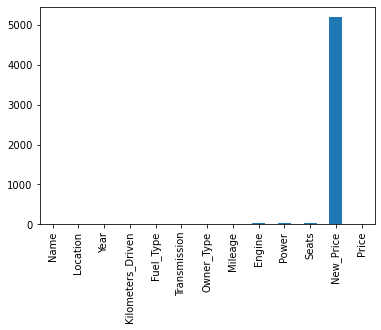

In [7]:
train.isnull().sum().plot.bar()

In [122]:
train0 = train

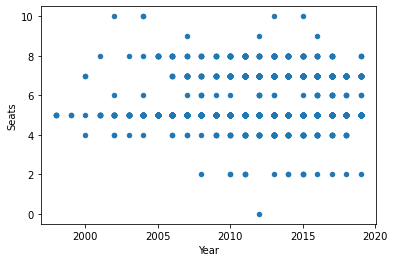

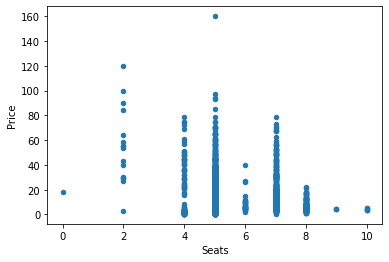

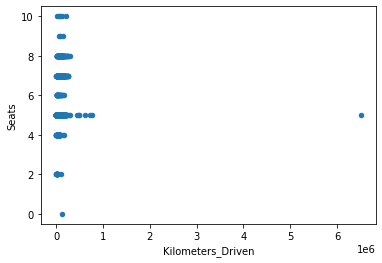

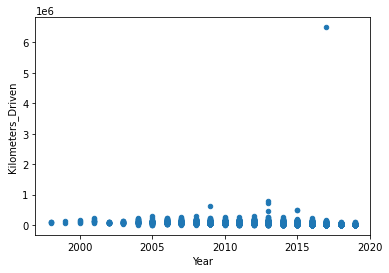

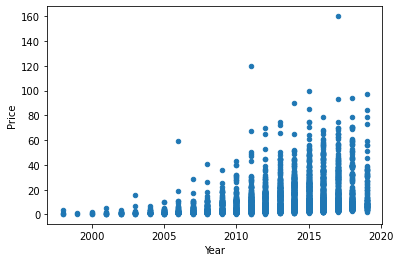

In [9]:
corr = train.corr().abs().unstack().sort_values(kind="quicksort").drop_duplicates()[-6:-1]
for i in corr.index:
    train.plot.scatter(x = i[0], y = i[1] )
plt.show()

# Задание 1.2 Подготовка признаков

Над признаками этого датасета нужно поработать немного больше.
1. Преобразуйте числовые признаки (Mileage, Power, Engine, New_Price) так, чтобы они были реально числами. Т.е. удалите лишнее и преобразуется в float
2. Извлеките из имени машины как минимум марку в качестве отдельного признака. Если у вас есть идеи для других признаков на основе Name (и любых других вообще), то реализуйте их. Стоит ли использовать признак Name напрямую?
3. Превратите выбранные категориальные признаки в числовые с помощью pd.get_dummies или любого другого способа, который вам нравится
4. Что будем делать с New_Price?

In [123]:
# переделать с этими разными еднинцами измерения!!!!!
train0.Mileage = train['Mileage'].apply(lambda x: float(x.split()[0])*1.4 if type(x) == str and x.endswith('km/kg') else float(x.split()[0]) if type(x) == str and x.endswith('kmpl') else 0 )

train0.Power = train['Power'].apply(lambda x: float(x.split()[0]) if type(x) == str and x.split()[0]!= 'null' else 0)

train0.Engine = train['Engine'].apply(lambda x: float(x.split()[0]) if type(x) == str else 0)

train0.New_Price = train['New_Price'].apply(lambda x: float(x.split()[0]) if type(x) == str else 0)

train0.Seats = train['Seats'].apply(lambda x: x if type(x) is not None else 0)

train0.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,37.24,998.0,58.16,5.0,0.00,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,0.00,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,0.00,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,0.00,17.74


In [11]:
train['Name'].describe() 

count                       6019
unique                      1876
top       Mahindra XUV500 W8 2WD
freq                          49
Name: Name, dtype: object

In [124]:
train0.Name = train.Name.apply(lambda x : x.split()[0])

<AxesSubplot:xlabel='Name'>

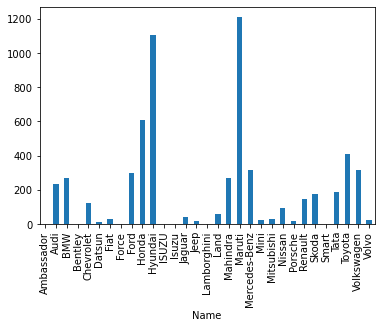

In [13]:
train0.groupby(by ='Name').size().plot.bar()

In [125]:
train1 = pd.get_dummies(train0)
train1.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,New_Price,Price,Name_Ambassador,Name_Audi,...,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,2010,72000,37.24,998.0,58.16,5.0,0.00,1.75,0,0,...,0,0,0,0,0,1,1,0,0,0
1,2015,41000,19.67,1582.0,126.20,5.0,0.00,12.50,0,0,...,1,0,0,0,0,1,1,0,0,0
2,2011,46000,18.20,1199.0,88.70,5.0,8.61,4.50,0,0,...,0,0,0,1,0,1,1,0,0,0
3,2012,87000,20.77,1248.0,88.76,7.0,0.00,6.00,0,0,...,1,0,0,0,0,1,1,0,0,0
4,2013,40670,15.20,1968.0,140.80,5.0,0.00,17.74,0,1,...,1,0,0,0,1,0,0,0,1,0


In [126]:
train1.Seats = train['Seats'].fillna(0)

In [160]:
X = train1.drop(['Price'],axis = 1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Задание 1.3 Анализ целевой переменной



**Проанализируйте целевую переменную в этом датасете**. Является ли она смещенной (skewed)? Для ответа на этот вопрос нарисуйте гистограмму с удачным количеством бинов.

Если она смещена, то опробуйте на ней np.log1p и PowerTransformer. Нарисуйте гистограммы преобразованных целевых переменных. Сделайте выводы.

Подготовьте целевые переменные и отделите ее от признаков. Для дальнейшей работы вам понадобится 2 варианта y:
1. Оригинанальный **y** без каких-либо изменений;
2. Y, который преобразован с помощью PowerTransformer. Назовем ее y_transformed. Кроме нее нам понадобится объект класса PowerTransformer, у которого вы вызывали fit_predict.

<AxesSubplot:>

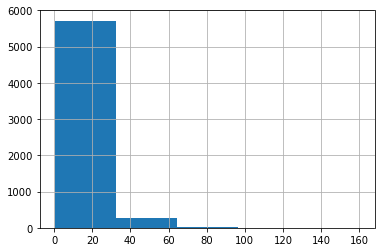

In [17]:
train1.Price.hist(bins=5)

<AxesSubplot:>

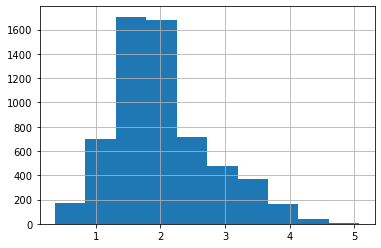

In [18]:
np.log1p(train1.Price).hist()

<AxesSubplot:>

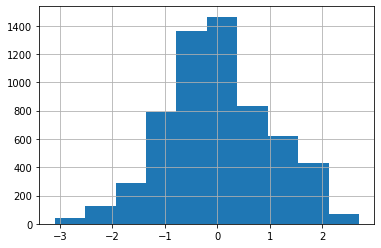

In [128]:
y = np.array(train1.Price).reshape(-1, 1)
pt = PowerTransformer()
y_transformed = pt.fit_transform(np.array(train1.Price).reshape(-1, 1)).flatten()
pd.Series(pt.fit_transform(np.array(train1.Price).reshape(-1, 1)).flatten()).hist()

In [20]:
#pt.fit_predict()?????

# Часть 2. Регрессия с помощью решающих деревьев

# Задание 2.1 Обучение решающих деревьев и кросс-валидация

ВНИМАНИЕ! В этот раз мы больше не разделяем данные с помощью train_test_split, а используем cross_val_score или cross_val_predict. Примеры использования тут https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics. Вам нужно явно указать mse в качестве метрики, если используете score и явно вычислять mean_squared_error в случае predict.

Проведите над этими данными следующие операции (не забывайте ВЕЗДЕ фиксировать random_state для воспроизводимости экспериментов. Без этого оценка за лабу **будет гореть**):
1. Обучить решающее дерево без каких либо ограничений
2. Обучить решающее дерево с ограничением глубины. Перебрать глубинут от 2 до 10 и нарисовать график изменения MSE в зависимости от глубины. Выбрать лучшую глубину
3. Обучить решающее дерево с зафиксированным ограничением глубины с прошлого пункта и изменением минимального числа примеров для разделения от 2 до 150 с шагом 5. Построить аналогичный график и выбрать лучшее значение

В каждом эксперименте вам нужно использовать cross_val_score/cross_val_predict с выбранным выше методом разбиения на фолды, чтобы измерить mean_squared_error. В качестве финального скора используйте среднее значение по всем фолдам. Также для каждого эксперимента оцените дисперсию оценки качества и сделайте выводы.

Наконец, подумайте, есть ли еще параметры, значения которых стоит перебирать в этой задаче? Если ответ - "да", то проведите соответствующие эксперименты. Если ответ - "нет", то будьте готовы пояснить, почему.


In [21]:
from sklearn.metrics import make_scorer

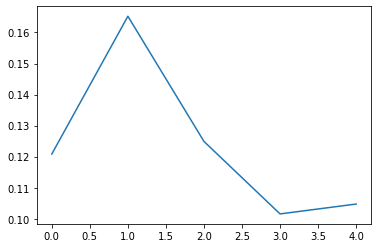

In [22]:
regressor1 = DecisionTreeRegressor(random_state = 0)
plt.plot(cross_val_score(regressor1,X,y_transformed,scoring = make_scorer(mean_squared_error)))

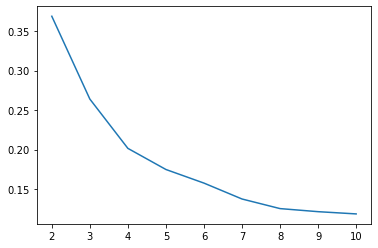

In [23]:
plt.figure()
ax = []
for i in range(2,11):
    regressor2 = DecisionTreeRegressor(random_state = 0,max_depth = i)
    ax.append(np.mean(cross_val_score(regressor2,X,y_transformed,scoring = make_scorer(mean_squared_error))))
plt.plot(range(2,11),ax)

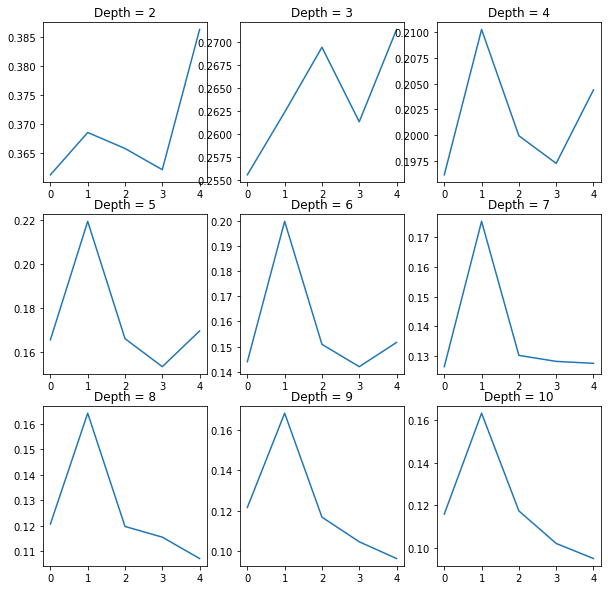

In [24]:
fig, axs = plt.subplots(3, 3,figsize=(10,10))
for i in range(2,11):
    regressor2 = DecisionTreeRegressor(random_state = 0,max_depth = i)
    axs[(i-2)//3,(i-2)%3].plot(cross_val_score(regressor2,X,y_transformed,scoring = make_scorer(mean_squared_error)))
    axs[(i-2)//3,(i-2)%3].set_title('Depth = '+ str(i))

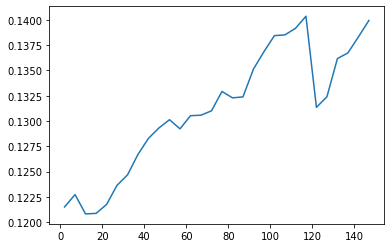

In [25]:
# переделать 
plt.figure()
ax = []
for i in range(2,151,5):
    regressor3 = DecisionTreeRegressor(random_state = 0,max_depth = 9,min_samples_split= i)
    ax.append(np.mean(cross_val_score(regressor3,X,y_transformed,scoring = make_scorer(mean_squared_error))))
plt.plot(range(2,151,5),ax)

# Задание 2.2 Визуализация решающих деревев

Дополнительно ознакомьтесь с возможностью визуализации решающих деревьев и объяснении их работы

Обучите дерево без использования признака Location и признаков на основе Name (иначе будет очень громоздкая картинка), с ограничением глубины 5-6 и нарисуйте его с помощью библиотеки eli5.

Для отрисовки используйте функцию explain_decision_tree. Будьте готовы устно описать то, что происходит на полученной картинке. Если ваше лучшее дерево получилось слишком большим, то ограничьте его глубину до 4, чтобы на рисунок было удобно рассматривать.

Для установки используйте команду **conda install -y -c conda-forge eli5** или установите ее через графический интерфейс.

Либо используйте для отрисовки метод из самой библиотеки scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html#sklearn.tree.plot_tree

In [26]:
from sklearn.tree import plot_tree

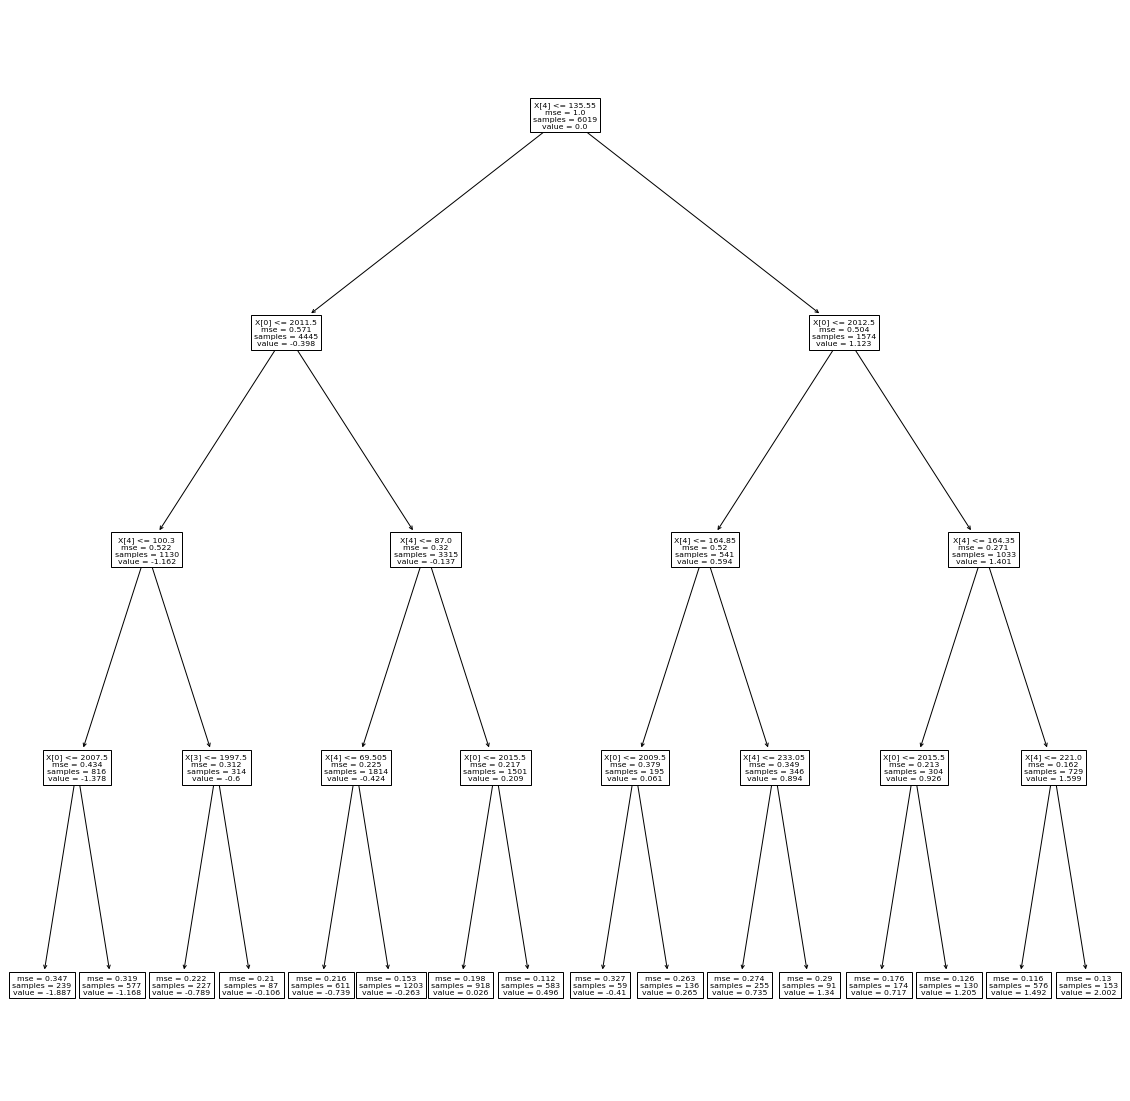

In [27]:
X2 = pd.get_dummies(train0.drop(['Location','Name','Price'],axis = 1).fillna(0))
regressor4 = DecisionTreeRegressor(random_state = 0,max_depth = 4)
regressor4.fit(X2,y_transformed)
plt.figure(figsize=(20,20))
plot_tree(regressor4)
plt.show()

In [28]:
explain_decision_tree(regressor4)

Weight,Feature
0.7212,x4
0.2727,x0
0.0061,x3
0,x16
0,x1
0,x2
0,x5
0,x6
0,x7
0,x17


# Часть 3. Регрессия с помощью линейных моделей

В этом разделе вам предстоит поработать с линейной регрессией, поиграть с регуляризацией, градиентным спуском и функционалами потерь. Используем тот же датасет, что и выше. Пока начинаем работать с исходной целевой переменной. Преобразованную оставим для соответствующего задания.

Дополнительно в этом разделе необходимо будет ознакомиться с GridSearchCV, чтобы перебирать параметры не независимо, а вместе. Совместный перебор разных гиперпараметров необходим в реальных задачах, так как параметры влияют друг на друга, а независимый перебор как в задании выше может привести к выбору конфигурации, которая значительно отличается от оптимальной.

# Часть 3.1 Перебор гиперпараметров

Ниже представлен пример набора гиперпараметров для передачи в GridSearchCV. Это словарь, в котором ключ - название параметра, а значение - список из параметров для перебора Обратите внимание, что общее число операций будет равно произведению длин всех списков параметров. Так что будьте аккуратны и не делайте их слишком много.

В качестве модели используйте либо ElasticNet (проще), либо SGDRegressor(чуть сложнее) на ваш выбор.

Список ниже указан только для примера. Один из параметров перебирать бессмысленно, так как он не влияет на модель. Поэтому:
1. Найдите его и удалите
2. Добавите параметры, которые важны для настройки, расширьте диапазон уже включенных параметров, если нужно. Будьте готовы объяснить ваш выбор.
3. Проведите поиск по сетке(возможно, придется сходить попить чай, пока будет вычисляться), обучите модель с лучшими параметрам и сравните ее качество с лучшим решающим дерево из предыдущего задания
4. **Hint**: Вполне возможно, что huber loss в данной задаче хороший выбор. Не забудьте проверить и его тоже


**Не забывайте стандартизировать признаки перед обучением линейных моделей!!**

In [29]:
# обратите внимание, что некоторые значения параметров бессмысленно перебирать при конкретных значениях других
# Для оптимизации времени (это только по вашему желанию) вам предлагается разобраться, что делать в этой ситуации

grid = {'penalty': ['l2', 'elasticnet'],
        'alpha': [1e-4, 1e-5, 1e-6, 5e-4, ],
        'l1_ratio': [0, 0.1, 0.15],
        'loss': ['huber'],
    }

In [30]:
search = GridSearchCV(SGDRegressor(random_state=33,shuffle=True), param_grid=grid, return_train_score=True,
                      cv=KFold(5, random_state=33,shuffle=True), verbose=1,
                      scoring='neg_mean_absolute_error', n_jobs=-1)

In [31]:
search.fit(X,y_transformed)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=33, shuffle=True),
             estimator=SGDRegressor(random_state=33), n_jobs=-1,
             param_grid={'alpha': [0.0001, 1e-05, 1e-06, 0.0005],
                         'l1_ratio': [0, 0.1, 0.15], 'loss': ['huber'],
                         'penalty': ['l2', 'elasticnet']},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [32]:
print(search.best_params_) 

{'alpha': 0.0001, 'l1_ratio': 0.15, 'loss': 'huber', 'penalty': 'elasticnet'}


In [33]:
search.score(X,y_transformed)

-0.2290343780441838

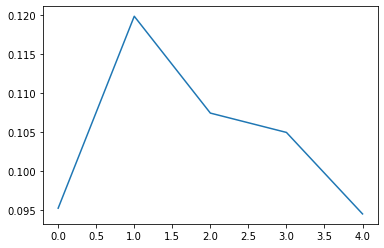

In [34]:
best = search.best_estimator_
plt.plot(cross_val_score(best,X,y_transformed,scoring = make_scorer(mean_squared_error)))

#### Обучите модель с лучшими предсказаниями и сделайте cross_val_predict. Постройте распределение предсказаний и целевой переменной. Сравните. Вычислите среднюю абсолютную и среднюю квадратичную ошибку модели.

Объясните вашу модель при помощи библиотеки eli5 (explain_linear_regressor_weights)

In [35]:
cross_val_predict(best,X,y_transformed)
explain_linear_regressor_weights(best)

Weight?,Feature
+0.490,x0
+0.273,x4
+0.160,x3
+0.105,x26
+0.097,x8
+0.096,x9
+0.084,x50
+0.062,x27
+0.058,x23
+0.048,x43


In [36]:
train1.drop('Price',axis = 1).columns

Index(['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats',
       'New_Price', 'Name_Ambassador', 'Name_Audi', 'Name_BMW', 'Name_Bentley',
       'Name_Chevrolet', 'Name_Datsun', 'Name_Fiat', 'Name_Force', 'Name_Ford',
       'Name_Honda', 'Name_Hyundai', 'Name_ISUZU', 'Name_Isuzu', 'Name_Jaguar',
       'Name_Jeep', 'Name_Lamborghini', 'Name_Land', 'Name_Mahindra',
       'Name_Maruti', 'Name_Mercedes-Benz', 'Name_Mini', 'Name_Mitsubishi',
       'Name_Nissan', 'Name_Porsche', 'Name_Renault', 'Name_Skoda',
       'Name_Smart', 'Name_Tata', 'Name_Toyota', 'Name_Volkswagen',
       'Name_Volvo', 'Location_Ahmedabad', 'Location_Bangalore',
       'Location_Chennai', 'Location_Coimbatore', 'Location_Delhi',
       'Location_Hyderabad', 'Location_Jaipur', 'Location_Kochi',
       'Location_Kolkata', 'Location_Mumbai', 'Location_Pune', 'Fuel_Type_CNG',
       'Fuel_Type_Diesel', 'Fuel_Type_Electric', 'Fuel_Type_LPG',
       'Fuel_Type_Petrol', 'Transmission_Automatic', 'Tran

<AxesSubplot:xlabel='Attribute'>

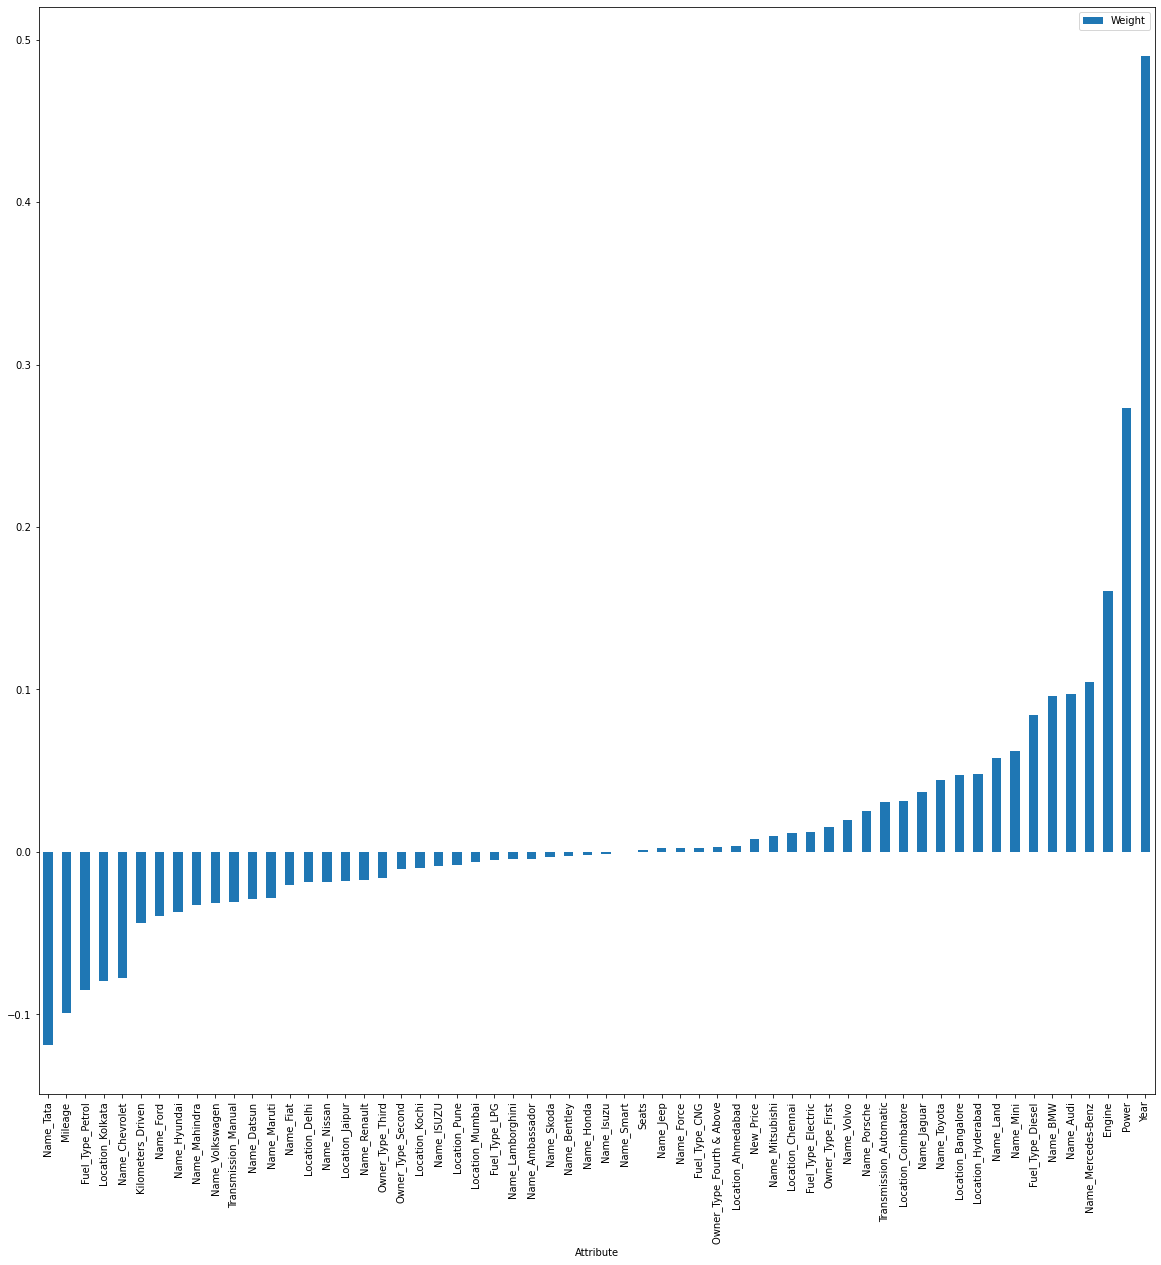

In [37]:
data = { 'Weight': best.coef_, 'Attribute': train1.drop('Price',axis = 1).columns}
pd.DataFrame(data).sort_values(by = 'Weight').plot.bar(x = 'Attribute',figsize = (20,20))

<AxesSubplot:>

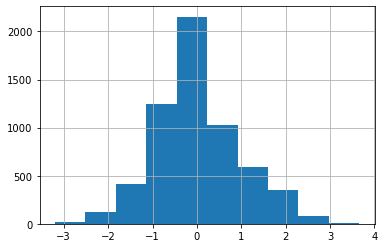

In [38]:
pd.Series(best.predict(X)).hist()

<AxesSubplot:>

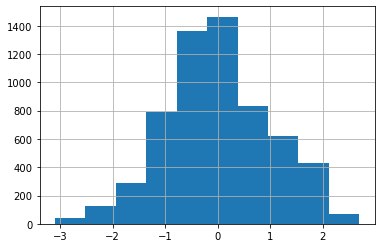

In [39]:
pd.Series(y_transformed).hist()

# Часть 3.2 Ограничение предсказаний линейной регрессии 

Мы обсуждали на лекции, что линейные модели без тормозов. Они не могут ограничивать диапазон своих предсказаний. В этом задании вам может быть полезно быстро им помочь, ограничив их после предсказания, что в теории может привести к улучшению общего качества.

Нужно сделать следующее:
- Определить, есть ли такая проблема в датасете, т.е. есть ли отрицательные предсказания или предсказания, которые сильно больше тех, что встречаются в обучающей выборки.  Если такого нет, то переходите дальше (это в теории может зависеть от ваших решений во время выполнения работы).
- Взять лучшую моделю, полученную на поиске, применить cross_val_predict (вместо cross_val_score) и использовать np.clip перед подачей предсказаний в метрику, сравнить со значениями без клиппинга и сделать выводы.

In [40]:
mean_squared_error(y_transformed,np.clip(cross_val_predict(best,X,y_transformed),min(y_transformed),max(y_transformed)))

0.10262984091979653

In [41]:
mean_squared_error(y_transformed,cross_val_predict(best,X,y_transformed))

0.10438349682383262

# Часть 3.3 * (На 10) Еще помогаем линейной регрессии соревноваться

Ничто не гарантирует, что перебор параметров выбрал бы именно эти, если бы np.clip проходил прямо внутри модели во время перебора. Чтобы наверняка выбрать лучшую модель, переопределите класс ElasticNet (или SGDRegressor) так, чтобы сразу после предикта предсказания за пределами диапазона датасета заменялись на минимум и максимум соответственно и проведите новый поиск по сетке.

Я уверен, что если до этого задания кто и доберется, то он наверняка без проблем сможет разобраться, как это реализовать. Если же вдруг будут вопросы, то милости прошу в slack.

In [42]:
class SGDRegressor0(SGDRegressor):
    def fit(self, X, y, sample_weight=None, check_input=True):
        self.max = max(y)
        self.min = min(y)
        super().fit( X, y, sample_weight, check_input)
        return self
    def predict(self, X):
        y = super().predict(X)
        return np.clip(y,self.min,self.max)

In [43]:
search33 = GridSearchCV(SGDRegressor0(random_state=33, shuffle = True), param_grid=grid, return_train_score=True,
                      cv=KFold(5, random_state=33,shuffle=True), verbose=1,
                      scoring='neg_mean_absolute_error', n_jobs=-1)
search30 = GridSearchCV(SGDRegressor(random_state=33, shuffle = True), param_grid=grid, return_train_score=True,
                      cv=KFold(5, random_state=33,shuffle=True), verbose=1,
                      scoring='neg_mean_absolute_error', n_jobs=-1)

In [44]:
search33.fit(X,y_transformed)
search30.fit(X,y_transformed)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=33, shuffle=True),
             estimator=SGDRegressor(random_state=33), n_jobs=-1,
             param_grid={'alpha': [0.0001, 1e-05, 1e-06, 0.0005],
                         'l1_ratio': [0, 0.1, 0.15], 'loss': ['huber'],
                         'penalty': ['l2', 'elasticnet']},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [45]:
print("SGDRegressor0: "+ str(mean_squared_error(y,search33.predict(X))))
print("SGDRegressor: "+ str(mean_squared_error(y,search30.predict(X))))

SGDRegressor0: 198.6053095356058
SGDRegressor: 198.2121919499256


# Часть 3.4. Преобразования целевой переменной

В этом задании вам необходимо сравнить качество работы линейной регрессии без и с преобразованием целевой переменной на основе наработок из задания 1.3

Для этого нужно взять взять заранее сохраненную целевую переменную y_transformed. А затем провести grid search снова. Лучшая модель в этом случае будет предсказывать преобразованную целевую переменную. Вернуться к изначальной необходимо, применив к предсказаниям inverse_transform у обученного объекта PowerTransformer.

**ВНИМАНИЕ**!! Без обратного преобразования результаты моделей несравнимы. Почему?


В конце концов, постройте гистограмму предсказаний в случаях с преобразованием и без него. Сравните с гистограммой целевой переменной. В каком случае распределение предсказаний выглядит более похожим на настоящее?

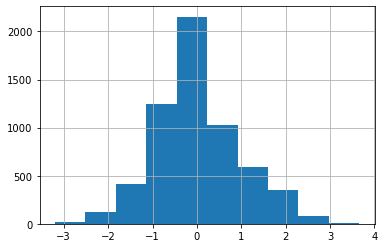

In [46]:
pd.Series(best.predict(X)).hist()
print()

<AxesSubplot:>

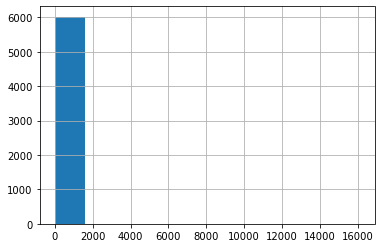

In [47]:
pd.Series(pt.inverse_transform(best.predict(X).reshape(-1,1)).flatten()).hist()

<AxesSubplot:>

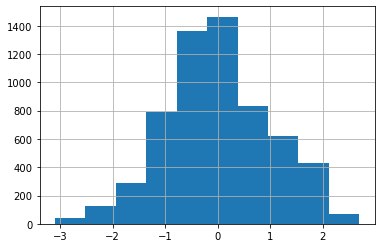

In [48]:
pd.Series(y_transformed).hist()

# Часть 3.5. Полноценный подбор гиперпараметров для решающего дерева

Название говорит само за себя. Проведите процедуру поиска по сетке важный параметров для дерева на этой же задаче. Объясните выбор своих параметров и будьте готовы отвечать на вопросы о их значении.

In [49]:
grid0 = {'criterion':["squared_error","absolute_error"],
         'splitter':['best','random'],
         'max_leaf_nodes':[10,50,100],
    }
search0 = GridSearchCV(DecisionTreeRegressor(random_state=33), param_grid=grid0, return_train_score=True,
                      cv=KFold(5, random_state=33,shuffle=True), verbose=1,
                      scoring='neg_mean_absolute_error', n_jobs=-1)

In [50]:
search0.estimator.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [51]:
search0.fit(X,y_transformed)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
 -0.36627541 -0.44317695 -0.27893578 -0.32874177 -0.25176385 -0.28875504
         nan         nan         nan         nan         nan         nan]
  warnings.warn(
/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [        nan         nan         nan         nan         nan         nan
 -0.36440003 -0.44399792 -0.25832969 -0.31324984 -0.2232414  -0.26275801
         nan         nan         nan         nan         nan         nan]
  warnings.warn(


GridSearchCV(cv=KFold(n_splits=5, random_state=33, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=33), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'mse',
                                       'absolute_error'],
                         'max_leaf_nodes': [10, 50, 100],
                         'splitter': ['best', 'random']},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [52]:
search0.best_estimator_

DecisionTreeRegressor(max_leaf_nodes=100, random_state=33)

In [53]:
mean_squared_error(y_transformed,search0.predict(X))

0.08730844915364039

In [54]:
mean_squared_error(y_transformed,cross_val_predict(regressor1,X,y_transformed))

0.12344704620060439

## Часть 3.5.1 (На оценку 9). Рандомизированный поиск гиперпараметров

Вы уже должны были ощутить на себе, что grid_search может занимать слишком много времени, так как перебирает все вохможные комбинации параметров, даже если в этом нет смысла. Тут может быть полезен RandomizedSearchCV. В этом случае вместо сетки параметров мы для дискретных параметров указываем диапазон, из которого нужно выбирать случайные значения, а дле непрерывных параметров (например, коэффициент регуляризации) указываем распределение, из которого нужно сэмплировать. 

В рамках этого подзадания вам нужно заменить во всем задании 3.4 GridSearchCV на RandomizedSearchCV и проанализировать полученные результаты. Пример использования прямо на странице документации метода: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#examples-using-sklearn-model-selection-randomizedsearchcv

In [55]:
random_search = RandomizedSearchCV(DecisionTreeRegressor(random_state=33), param_distributions=grid0, return_train_score=True,
                      cv=KFold(5, random_state=33,shuffle=True), verbose=1,
                      scoring='neg_mean_absolute_error', n_jobs=-1)
random_search.fit(X,y_transformed)
random_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan -0.25176385 -0.32874177 -0.27893578
         nan         nan         nan         nan]
  warnings.warn(
/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [        nan         nan         nan -0.2232414  -0.31324984 -0.25832969
         nan         nan         nan         nan]
  warnings.warn(


DecisionTreeRegressor(max_leaf_nodes=100, random_state=33)

In [56]:
mean_squared_error(y_transformed,random_search.predict(X))

0.08730844915364039

In [57]:
mean_squared_error(y_transformed,search0.predict(X))

0.08730844915364039

In [58]:
random_search0 = RandomizedSearchCV(SGDRegressor(random_state=33,shuffle=True), param_distributions=grid, return_train_score=True,
                      cv=KFold(5, random_state=33,shuffle=True), verbose=1,
                      scoring='neg_mean_absolute_error', n_jobs=-1)
random_search0.fit(X,y_transformed)
random_search0.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


SGDRegressor(l1_ratio=0.1, loss='huber', penalty='elasticnet', random_state=33)

In [59]:
mean_squared_error(y_transformed,random_search0.predict(X))

0.09947312919576701

In [60]:
mean_squared_error(y_transformed,search.predict(X))

0.09945561454693726

# Часть 3.6* (На 10). Первые шаги в смешивании моделей

По результатам работы выше у вас получилось 2 модели разной природы. Известно, что смешивание разных моделей улучшает качество работы, так как они предсказывают **по-разному**.
Самый простой способ смешивания - усреднение предсказаний с весами. Ваша задача - сделать такое усреднение и подобрать лучшие веса. Важно, чтобы для двух моделей использовалась **ИДЕНТИЧНАЯ** схема разбиения на фолды.

In [61]:
y_transformed.size

6019

SGDRegressor(loss='huber', penalty='elasticnet', random_state=33)
DecisionTreeRegressor(max_leaf_nodes=100, random_state=33)
a1:0.4044216770151075
a2:0.5955783229848925


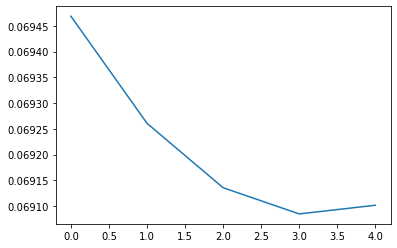

In [70]:
# model1 = search.best_estimator_.fit(X, y_transformed)
# model2 = search0.best_estimator_.fit(X, y_transformed)
# y1 = model1.predict(X)
# y2 = model2.predict(X)
print(search.best_estimator_)
print(search0.best_estimator_)
y1 = search.predict(X)
y2 = search0.predict(X)
a1 = a2 = 0.5;
n = y_transformed.size
er = []
for i in range(0,5):
    er.append(mean_squared_error(y_transformed, (a1*y1+a2*y2)/(a1+a2)))
#     print(str(i+1)+':'+str(er[i]))
    a1 = a1 - 0.02* (2/n)*(np.sum((a1*y1+a2*y2)/(a1+a2)-y_transformed)*(a2/((a1+a2)**2)*np.sum(y1 - y2)))
    a2 = a2 - 0.02* (2/n)*(np.sum((a1*y1+a2*y2)/(a1+a2)-y_transformed)*(a1/((a1+a2)**2)*np.sum(y2 - y1)))
plt.plot(er)
print('a1:' + str(a1/(a1+a2)))
print('a2:' + str(a2/(a1+a2)))

# Часть 4. Возможность исправить проблемы с прошлыми или будущими лабами. Либо узнать что-то новое для тех, у кого проблем нет

Отдельное задание для того, чтобы поправить среднюю оценку. К лабе оно напрямую не относится. Этим же заданием хорошим, но ленивым студентам  дается возможность исправить возможные проблемы. Если его выполнить и защитить, то можно получить дополнительную десятку, которая, очевидно, хорошо повлияет на оценку. Выполнять можно до конца ноября. 

У вас есть 3 варианта на выбор:
1. Реализовать линейную регрессию с регуляризацией в общем виде(ElasticNet), которая обучается с помощью стохастического градиентного спуска.
2. Реализовать решающее дерево вместе с процессом обучением. Конкретный вариант дерева остается на ваш выбор(например, CART). Работаем только с классификацией, а в качестве критерия рассматриваем индекс Джини или энтропийный критерий.
3. Вариант для самых суровых. Существует еще один любопытный вариант решающих деревьев: linear tree. Это такие решающие деревья, в которых к листьях вместо константы находятся линейные модели, лучше всего приблежающие данные, которые до этого листа дошли. Хитро, не правда ли? Таким образом, для выполнения этого пунка нужна как реализация линейных моделей, так и реализация решающих деревьев. Линейную модель можно взять из sklearn, а вот дерево придется написать самостоятельно. Детали смотреть в https://arxiv.org/abs/1802.05640 .

После выполнения задания проверьте вашу реализацию на датасете из этой лабы и сравните результаты.

P.S. Все варианты выполнять точно не нужно, за это никаких дополнительных плюшек не будет. Пожалейте себя. Вариант 3 рекомендуется выполнять только в случае внутреннего ощущения крайней творческой необходимости.


Самое главное: код должен быть написан и защищен вами. Сдать слегка измененный код из интернета сдать не получится.

In [174]:
class MyElasticNet():
    
    def __init__(self,l1_ratio = 0.5,max_iterations = 100, alpha = 1, tol = 0.0001, learning_rate = 0.01):
        self.lambda1 = l1_ratio
        self.lambda2 = 1 - l1_ratio
        self.alpha = alpha
        self.tol = tol
        self.max_iter = max_iterations
        self.learning_rate = learning_rate
        
    def fit(self,X,y):
        self.weights = np.random.rand(X.shape[0],1)
        self.bias = np.random.rand(1)
        iteration = 0
        self.error = [self.count_elasticnet_function(X,y)]
        self.shape = X.shape[1]
        while self.count_elasticnet_function(X,y) > self.tol and iteration < self.max_iter:
            iteration += 1
            index = np.random.randint(X.shape[1])
            self.error.append(self.count_elasticnet_function(X,y))
            self.count_gradient(X[:,index],y[index])
            self.bias -= self.learning_rate*self.db
            self.weights -= self.learning_rate*self.dw.T
        
    def count_gradient(self,X,y):
        self.db = -2 * np.sum(y - (np.dot(self.weights.T,X)+ self.bias)) + self.lambda1*np.sign(self.bias) + 2*self.lambda2*self.bias
        self.dw = -2*np.multiply(X,(y - (np.dot(self.weights.T,X)+ self.bias))) + self.alpha*self.lambda1*np.sign(self.weights).T + self.alpha*2*self.lambda2*self.weights.T
        
            
    def count_elasticnet_function(self,X,y):
        return  np.mean(np.sum((y - np.dot(self.weights.T,X) + self.bias)**2).T + self.alpha*self.lambda1* np.abs(self.weights)+ (self.alpha*self.lambda2* (self.weights)**2))
        
    def predict(self,X):
        return np.dot(self.weights.T,X)+ self.bias
        
    def graph(self):
        plt.plot(np.array(self.error).flatten())
        plt.show()
    

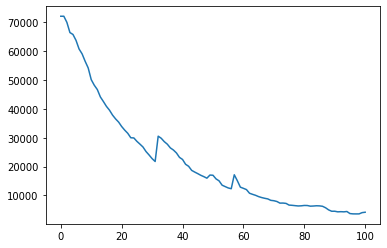

In [192]:
en = MyElasticNet(tol = 1e-10,max_iterations = 100)
en.fit(X.T,y_transformed)
en.graph()

In [193]:
en.count_elasticnet_function(X.T,y_transformed)

3430.8324115214755